In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [4]:
# Dataset contains PILImage of size [0, 1]
# Convert to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [5]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

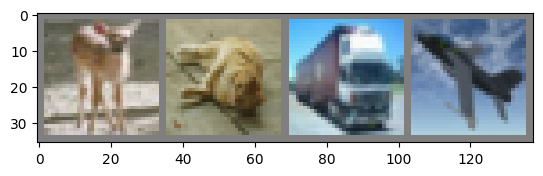

In [6]:
def imshow(img: torch.Tensor):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Formula: (W - F + 2P)/S + 1


In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # input channels = color channels = 3, kernel size = 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)  # stride = 2 for right
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 16*5*5 after flattening input from last conv layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()  # Auto applies Softmax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 2000 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}"
            )

Epoch [1/5], Step [2000/12500], Loss: 2.2496
Epoch [1/5], Step [4000/12500], Loss: 2.2947
Epoch [1/5], Step [6000/12500], Loss: 2.3173
Epoch [1/5], Step [8000/12500], Loss: 2.3177
Epoch [1/5], Step [10000/12500], Loss: 2.2738
Epoch [1/5], Step [12000/12500], Loss: 2.3736
Epoch [2/5], Step [2000/12500], Loss: 1.8452
Epoch [2/5], Step [4000/12500], Loss: 1.8979
Epoch [2/5], Step [6000/12500], Loss: 1.6981
Epoch [2/5], Step [8000/12500], Loss: 2.1416
Epoch [2/5], Step [10000/12500], Loss: 2.0321
Epoch [2/5], Step [12000/12500], Loss: 1.8743
Epoch [3/5], Step [2000/12500], Loss: 1.5946
Epoch [3/5], Step [4000/12500], Loss: 2.1968
Epoch [3/5], Step [6000/12500], Loss: 0.9886
Epoch [3/5], Step [8000/12500], Loss: 1.3191
Epoch [3/5], Step [10000/12500], Loss: 2.0112
Epoch [3/5], Step [12000/12500], Loss: 1.3778
Epoch [4/5], Step [2000/12500], Loss: 0.9125
Epoch [4/5], Step [4000/12500], Loss: 1.2660
Epoch [4/5], Step [6000/12500], Loss: 0.9607
Epoch [4/5], Step [8000/12500], Loss: 1.1708
Epoc

In [11]:
PATH = "./model/cnn.pth"
torch.save(model.state_dict(), PATH)

In [12]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f"Accuracy of {classes[i]}: {acc} %")

Accuracy of the network: 48.95 %
Accuracy of plane: 49.1 %
Accuracy of car: 63.1 %
Accuracy of bird: 21.3 %
Accuracy of cat: 38.1 %
Accuracy of deer: 34.0 %
Accuracy of dog: 32.1 %
Accuracy of frog: 71.1 %
Accuracy of horse: 62.0 %
Accuracy of ship: 69.0 %
Accuracy of truck: 49.7 %
